<a href="https://colab.research.google.com/github/joefreire/previsao/blob/main/Previsao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [321]:
from google.colab import files, drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# elimina os warnings das bibliotecas
import warnings
warnings.filterwarnings("ignore")

from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot


 
df = pd.read_csv('/content/drive/MyDrive/previsao/dataset.csv', thousands=',')
df["Escopo1"]=df["Escopo1"].astype(float)
df["Escopo2"]=df["Escopo2"].astype(float)
df["Escopo3"]=df["Escopo2"].astype(float)
df['Ref']=pd.to_datetime(df['Ref'])
df.set_index('Ref',inplace=True)

escopo1 = df.filter(['Ref','Escopo1'], axis=1)


escopo1.head()


,Escopo1
Ref,
2016-01-01,56077615.0
2016-02-01,44377551.0
2016-03-01,30970758.0
2016-04-01,13966298.0
2016-05-01,4044635.0


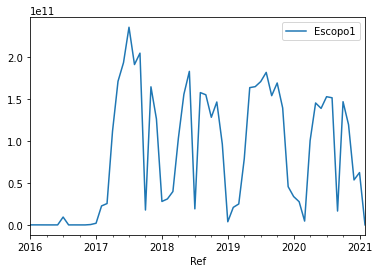

In [ ]:
escopo1.plot()

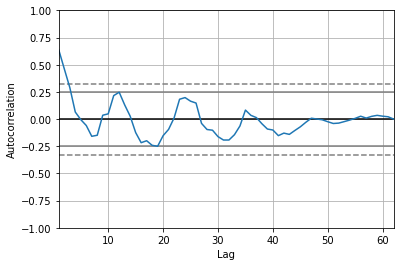

In [ ]:
autocorrelation_plot(escopo1)
pyplot.show()

In [ ]:
### Teste da amostra
from statsmodels.tsa.stattools import adfuller
test_result=adfuller(escopo1['Escopo1'])
#Ho: amostra não estacionaria
#H1: amostra estacionaria

def adfuller_test(amostra):
    result=adfuller(amostra)
    labels = ['ADF Test Statistic','p-value','#Lags Used','observações']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("forte evidência contra a hipótese nula (Ho), rejeite a hipótese nula. Os dados não têm raiz unitária e são estacionários")
    else:
        print("evidência fraca contra hipótese nula, a série temporal tem uma raiz unitária, indicando que é não estacionária ")


adfuller_test(escopo1['Escopo1'])

ADF Test Statistic : -2.386812491709376
p-value : 0.1454931314838221
#Lags Used : 8
observações : 53
evidência fraca contra hipótese nula, a série temporal tem uma raiz unitária, indicando que é não estacionária 


In [ ]:
escopo1['Primeira Diferenciação'] = escopo1['Escopo1'] - escopo1['Escopo1'].shift(1)
escopo1['Escopo1'].shift(1)

Ref
2016-01-01             NaN
2016-02-01    5.607762e+07
2016-03-01    4.437755e+07
2016-04-01    3.097076e+07
2016-05-01    1.396630e+07
                  ...     
2020-10-01    1.652933e+10
2020-11-01    1.468598e+11
2020-12-01    1.195233e+11
2021-01-01    5.361013e+10
2021-02-01    6.239695e+10
Name: Escopo1, Length: 62, dtype: float64

In [ ]:
escopo1['Diferença Sazonal']=escopo1['Escopo1']-escopo1['Escopo1'].shift(12)
escopo1.head(14)

,Escopo1,Diferença Sazonal,Primeira Diferenciação
Ref,,,
2016-01-01,5.607762e+07,NaN,NaN
2016-02-01,4.437755e+07,NaN,-1.170006e+07
2016-03-01,3.097076e+07,NaN,-1.340679e+07
2016-04-01,1.396630e+07,NaN,-1.700446e+07
2016-05-01,4.044635e+06,NaN,-9.921663e+06
2016-06-01,2.007882e+07,NaN,1.603419e+07
2016-07-01,9.368829e+09,NaN,9.348750e+09
2016-08-01,1.626783e+06,NaN,-9.367202e+09
2016-09-01,1.786098e+07,NaN,1.623420e+07


In [ ]:
## dickey fuller test
adfuller_test(escopo1['Diferença Sazonal'].dropna())

ADF Test Statistic : -5.322551419881858
p-value : 4.916411536347387e-06
#Lags Used : 11
observações : 38
forte evidência contra a hipótese nula (Ho), rejeite a hipótese nula. Os dados não têm raiz unitária e são estacionários


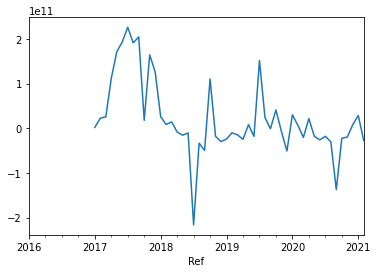

In [ ]:
escopo1['Diferença Sazonal'].plot()

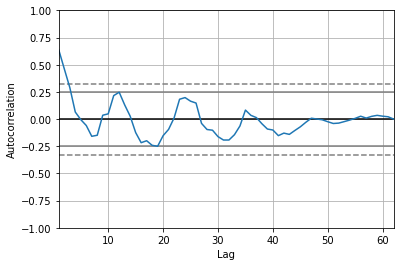

In [ ]:
autocorrelation_plot(escopo1['Escopo1'])
plt.show()

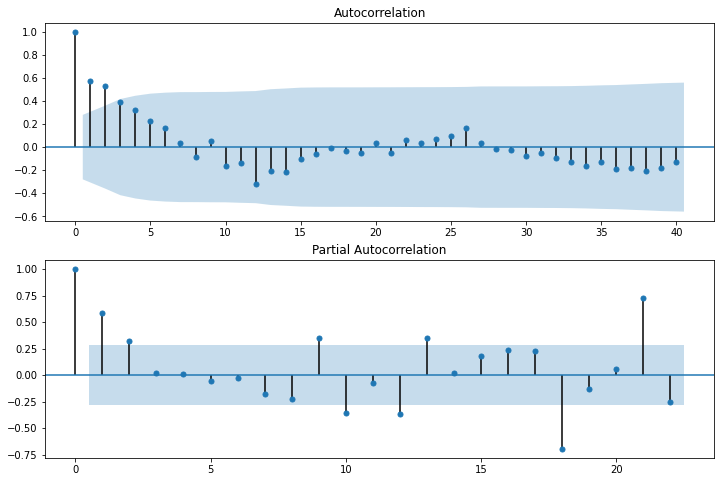

In [ ]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(escopo1['Diferença Sazonal'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(escopo1['Diferença Sazonal'].iloc[13:],lags=22,ax=ax2)

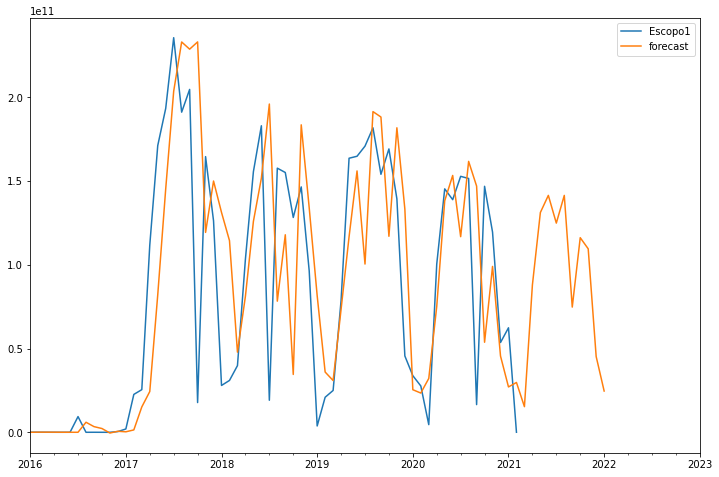

In [314]:

from pandas.tseries.offsets import DateOffset
model=sm.tsa.statespace.SARIMAX(escopo1['Escopo1'],order=(4, 2, 1),seasonal_order=(1,1,1,12))
results=model.fit()
future_dates=[escopo1.index[-1]+ DateOffset(months=x)for x in range(0,24)]
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=escopo1.columns)
future_df=pd.concat([escopo1,future_datest_df])

future_df['forecast'] = results.predict(end = 72)  

future_df[['Escopo1', 'forecast']].plot(figsize=(12, 8))


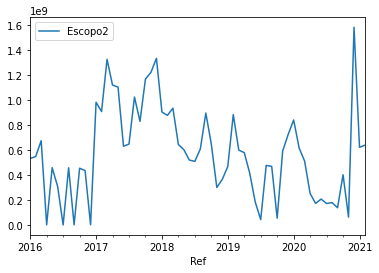

In [322]:
#dados escopo2
escopo2 = df.filter(['Ref','Escopo2'], axis=1)

#tratamento dos dados vazios, quando 0 eu busco ou a media do mês ou a media do ano
for index, row in escopo2.iterrows():
    if row['Escopo2'] <= 0:
      mediaMes = escopo2['Escopo2'].groupby([escopo2.index.month]).mean()[index.month]
      if mediaMes == 0.0:
         mediaAno = escopo2['Escopo2'].groupby([escopo2.index.year]).mean()[index.year]
         row['Escopo2'] = mediaAno
      else:
         row['Escopo2'] = mediaMes
escopo2.plot()


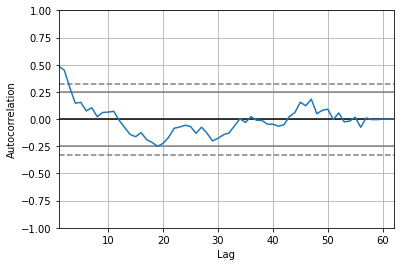

In [300]:
autocorrelation_plot(escopo2)
pyplot.show()


In [301]:
adfuller_test(escopo2['Escopo2'])

ADF Test Statistic : -2.869516766591125
p-value : 0.04900935003773476
#Lags Used : 1
observações : 60
forte evidência contra a hipótese nula (Ho), rejeite a hipótese nula. Os dados não têm raiz unitária e são estacionários


In [302]:
escopo2['Primeira Diferenciação'] = escopo2['Escopo2'] - escopo2['Escopo2'].shift(1)
escopo2['Diferença Sazonal']=escopo2['Escopo2']-escopo2['Escopo2'].shift(12)
print(escopo2)

                 Escopo2  Primeira Diferenciação  Diferença Sazonal
Ref                                                                
2016-01-01  5.320422e+08                     NaN                NaN
2016-02-01  5.468600e+08            1.481772e+07                NaN
2016-03-01  6.735194e+08            1.266594e+08                NaN
2016-04-01  1.226124e+06           -6.722933e+08                NaN
2016-05-01  4.581142e+08            4.568881e+08                NaN
2016-06-01  3.078998e+08           -1.502144e+08                NaN
2016-07-01  4.583390e+05           -3.074415e+08                NaN
2016-08-01  4.572874e+08            4.568291e+08                NaN
2016-09-01  1.018876e+06           -4.562685e+08                NaN
2016-10-01  4.538855e+08            4.528666e+08                NaN
2016-11-01  4.347973e+08           -1.908818e+07                NaN
2016-12-01  1.651778e+06           -4.331456e+08                NaN
2017-01-01  9.813139e+08            9.796621e+08

In [304]:
## dickey fuller test
adfuller_test(escopo2['Diferença Sazonal'].dropna())


ADF Test Statistic : -5.532882333825535
p-value : 1.7711975240347864e-06
#Lags Used : 11
observações : 38
forte evidência contra a hipótese nula (Ho), rejeite a hipótese nula. Os dados não têm raiz unitária e são estacionários


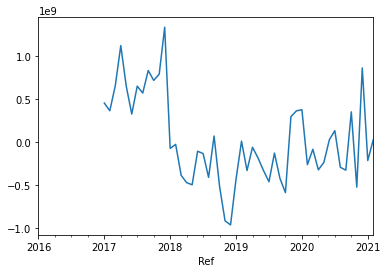

In [305]:
escopo2['Diferença Sazonal'].plot()

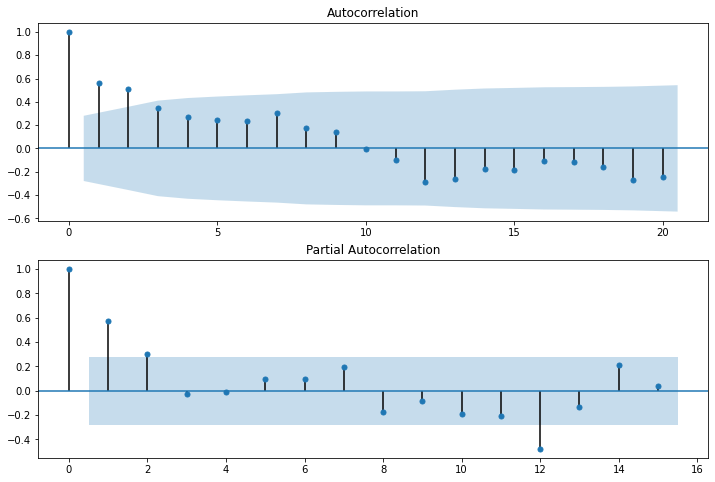

In [306]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(escopo2['Diferença Sazonal'].iloc[13:],lags=20,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(escopo2['Diferença Sazonal'].iloc[13:],lags=15,ax=ax2)

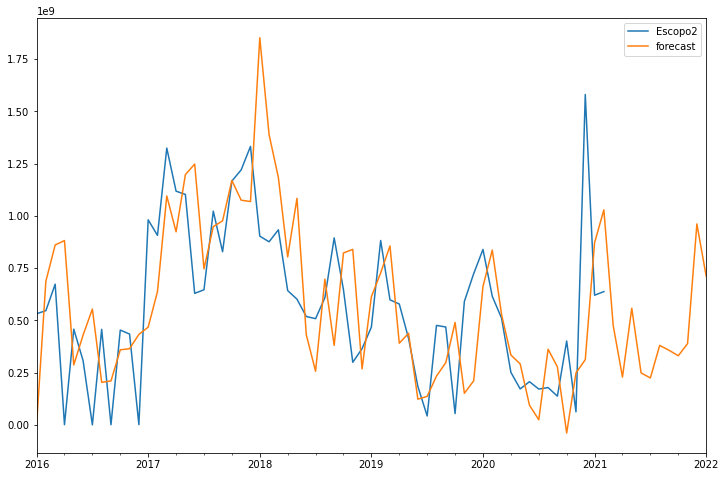

In [323]:
#essa é o modelo que foi aprendido para as previsões
model2=sm.tsa.statespace.SARIMAX(escopo2['Escopo2'],order=(4, 2, 1),seasonal_order=(1,1,1,12))
results2=model2.fit()

future_dates2=[escopo2.index[-1]+ DateOffset(months=x)for x in range(0,12)]
future_datest2_df=pd.DataFrame(index=future_dates2[1:],columns=escopo2.columns)
future_df2=pd.concat([escopo2,future_datest2_df])


future_df2['forecast'] = results2.predict(end=72)  

future_df2[['Escopo2', 'forecast']].plot(figsize=(12, 8))



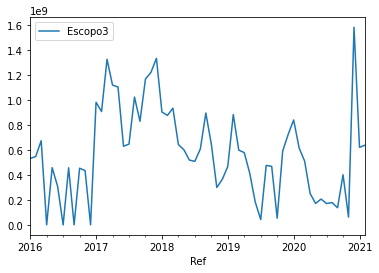

In [324]:

#dados escopo3
escopo3 = df.filter(['Ref','Escopo3'], axis=1)

#tratamento dos dados vazios, quando 0 eu busco ou a media do mês ou a media do ano
for index, row in escopo3.iterrows():
    if row['Escopo3'] <= 0:
      mediaMes = escopo3['Escopo3'].groupby([escopo3.index.month]).mean()[index.month]
      if mediaMes == 0.0:
         mediaAno = escopo3['Escopo3'].groupby([escopo3.index.year]).mean()[index.year]
         row['Escopo3'] = mediaAno
      else:
         row['Escopo3'] = mediaMes
escopo3.plot()